In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy.ma as ma
import numpy.linalg as linalg
from scipy.stats.stats import pearsonr

# Estadística
from scipy import stats 
from scipy import special

# Cartografía 
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from cartopy.util import add_cyclic_point
import cartopy.io.shapereader as shpreader

# Lectura de datos
from netCDF4 import Dataset
import xarray as xr

# Índices Climáticos
from xclim.core.calendar import percentile_doy
from xclim.indices import tn10p, tx10p

from scipy.fft import fft 
from statsmodels.tsa import stattools 
from scipy import signal

import warnings
warnings.filterwarnings('ignore')

In [2]:
path='/Users/barbo/Desktop/analisis multivariante/indices/'
file1='Tn10p_ESP_nan.nc'
tn10 = xr.open_dataset(path+file1)

In [30]:
tn10=tn10.__xarray_dataarray_variable__


In [31]:
#remallado de la matriz para coger la mitad de los puntos¡:
tn10_remallado=tn10.interp(lat=tn10.lat[::2]).interp(lon=tn10.lon[::2])
tn10_remallado=tn10_remallado.set_index(lon='x')
tn10_remallado=tn10_remallado.set_index(lat='y')

In [32]:
tn10_remallado

<xarray.DataArray '__xarray_dataarray_variable__' (time: 1368, lat: 95, lon: 115)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 1901-01-01 1901-02-01 ... 2014-12-01
  * lat      (lat) float64 44.17 44.08 43.99 43.9 ... 35.98 35.89 35.8 35.71
  * lon      (lon) float64 -9.673 -9.556 -9.439 -9.322 ... 3.431 3.548 3.665

In [33]:
lon=tn10_remallado.lon
lat=tn10_remallado.lat

time=tn10_remallado.time

In [34]:
nlon=lon.shape[0]
nlat=lat.shape[0]
nt=time.shape[0]

nyears= int(nt/12)
nyears

114

In [35]:
def season(Z,e1,e2,nyrs):
#para que funcione los datos Z tienen que estar con dimensiones nyrs,12,ns
#e1 y e2 son los meses inicial y final de las estaciones
#e1=2;e2=4 ;esta='MAM';
#e1=5;e2=7 ;esta='JJA';
#e1=6;e2=8 ;esta='JAS';
#e1=8;e2=10 ;esta='SON';
#e1=11;e2=1 ;esta='DJF';
#e1=10;e2=1 ;esta='NDJF';
   
    if e1==11:
        Zs1= Z[:-1,e1,:]
        Zs2= Z[1:,:e2,:].mean(1)
        n1=1
        n2=e2+1
        Zs=(Zs1*n1+Zs2*n2)/(n1+n2)
        nyrs=nyrs-1
    elif e1>e2:
        Zs1= Z[:-1,e1:11,:].mean(1)
        Zs2= Z[1:,:e2,:].mean(1)
        n1=12-e1
        n2=e2+1
        Zs=(Zs1*n1+Zs2*n2)/(n1+n2)
        nyrs=nyrs-1
    else:
        Zs = Z[:,e1:e2,:].mean(1)

    return Zs ,nyrs

# Esta función te proporciona anomalías ya sean estandarizadas o no, al introducir un campo con dimension (espacio,tiempo)
def anom(X, nyr, par):
    # si par = st quiere decir que estandarizo. Si no, no (pongo, por ejemplo,'pp')
    ns, nt = np.shape(X)  # una de las dimensiones es tiempo, la segunda, y la otra puede ser el numero de modos, o de espacios..
    nmes = int(nt / (nyr));

    # dividimos el número de tiempos por el numero de años porque en caso de que queramos calcular
    # anomalias estacionales de una secuencia mensual (enero-media(diciembre-enero-febrero)) en lugar de una media estacional

    An = ma.empty([ns, nt])

    for i in range(ns):
        A = X[i, :].reshape(nyr, nmes)
        mA = np.mean(A)
        for j in range(0, nyr):
            A[j, :] = A[j, :] - mA

        if par == 'st':

            stdA = ma.empty([nmes, ])
            for k in range(nmes):
                stdA[k] = np.std(A[:, k])
                if stdA[k] != 0:
                    A[:, k] = A[:, k] / stdA[k]

        # se reorganizan los datos
        A = np.transpose(A.reshape(nyr * nmes, 1))
        An[i, :] = A;

    return An

In [36]:
tn10_remallado_prim=tn10_remallado.groupby('time.season')['DJF']

In [37]:
tn10_remallado_prim

<xarray.DataArray '__xarray_dataarray_variable__' (time: 342, lat: 95, lon: 115)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 1901-01-01 1901-02-01 ... 2014-12-01
  * lat      (lat) float64 44.17 44.08 43.99 43.9 ... 35.98 35.89 35.8 35.71
  * lon      (lon) float64 -9.673 -9.556 -9.439 -9.322 ... 3.431 3.548 3.665

In [38]:
lon = tn10_remallado_prim.lon
lat = tn10_remallado_prim.lat
time = tn10_remallado_prim.time
nm = 12
nyears = int(tn10_remallado_prim.time.shape[0]/nm)

In [40]:
tn10_primavera_anomalia= tn10_remallado_prim-tn10_remallado_prim.mean(axis=0)

In [41]:
[nt,nlat,nlon]=tn10_primavera_anomalia.shape

In [42]:
tn10_primavera_anomalia=np.reshape(np.array(tn10_primavera_anomalia), (int(nt/3),3,nlat,nlon)).mean(axis=1)

In [43]:
tn10_primavera_anomalia.shape

(114, 95, 115)

In [44]:
# primero hay que poner los datos como una matriz (espacio, tiempo), para poder correr las funciones
tn10_prim_nans=np.reshape(tn10_primavera_anomalia,(114,nlat*nlon))
tn10_prim_nans.shape

(114, 10925)

In [45]:
def quitonans(mat):
    out = mat[:,~np.isnan(mat.mean(axis = 0))]
    return out

def pongonans(matred,mat):
    out = mat.mean(axis = 0 )
    out[:] = np.nan
    out[~np.isnan(mat.mean(axis = 0))] = matred
    return out

In [46]:
tn10_primavera_sin_nan=quitonans(tn10_prim_nans)
tn10_primavera_sin_nan.shape
# Ahora tenemos una matriz TIEMPO ESPACIO sin los valores nan

(114, 5049)

In [47]:
C=np.dot(np.transpose(tn10_primavera_sin_nan),tn10_primavera_sin_nan)
# C tiene que ser una matriz ESPACIO-ESPACIO

In [48]:
C.shape

(5049, 5049)

In [49]:
eof_tn10,d_tn10,eof2_tn10=linalg.svd(C)

In [50]:
fvar_tn10=(d_tn10)/sum(d_tn10)

sum(fvar_tn10[:10])

0.8859911283136249

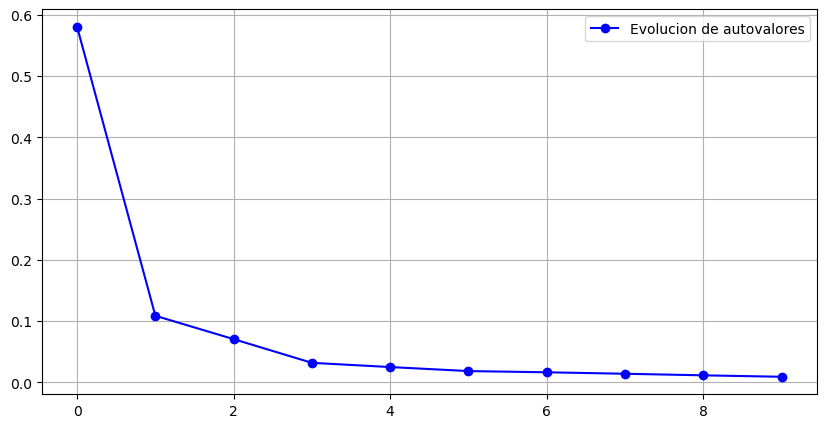

In [51]:
fig,ax = plt.subplots(figsize = (10,5))
plt.plot(fvar_tn10[:10],color='Blue',marker='o',label='Evolucion de autovalores')
plt.legend()
plt.grid()

In [52]:
PC=np.dot(tn10_primavera_sin_nan,eof_tn10[:,:4])

In [53]:
PC.shape

(114, 4)

In [54]:
PCs=(PC-np.mean(PC))/np.std(PC)

In [55]:
modo =1 
PC1s=PCs[:,0:4]
PC1s.shape

(114, 4)

Text(0.5, 1.0, 'Primera componente principal fvar=0.58')

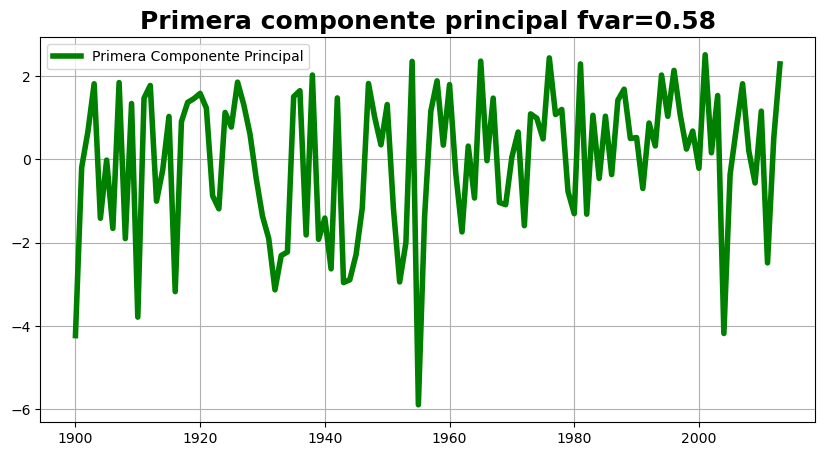

In [58]:
fig,ax=plt.subplots(figsize = (10,5))
ax.plot(range(1900,2014),PC1s[:,0],linewidth= 4,color='green',label='Primera Componente Principal')
ax.grid()
ax.legend()
ax.set_title('Primera componente principal fvar='+ str( round(fvar_tn10[0],2)),fontsize=18,weight='bold')


Text(0.5, 1.0, 'segunda componente principal fvar=0.11')

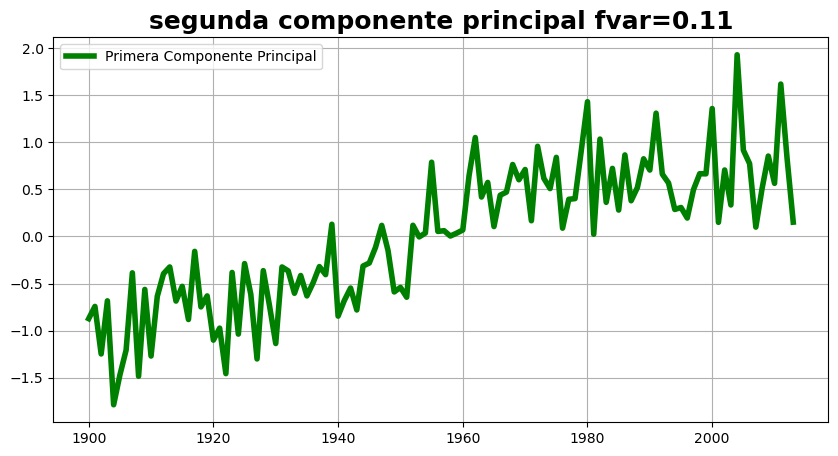

In [61]:
fig,ax=plt.subplots(figsize = (10,5))
ax.plot(range(1900,2014),PC1s[:,1],linewidth= 4,color='green',label='Primera Componente Principal')
ax.grid()
ax.legend()
ax.set_title('segunda componente principal fvar='+ str( round(fvar_tn10[1],2)),fontsize=18,weight='bold')


Text(0.5, 1.0, 'Tercera componente principal fvar=0.07')

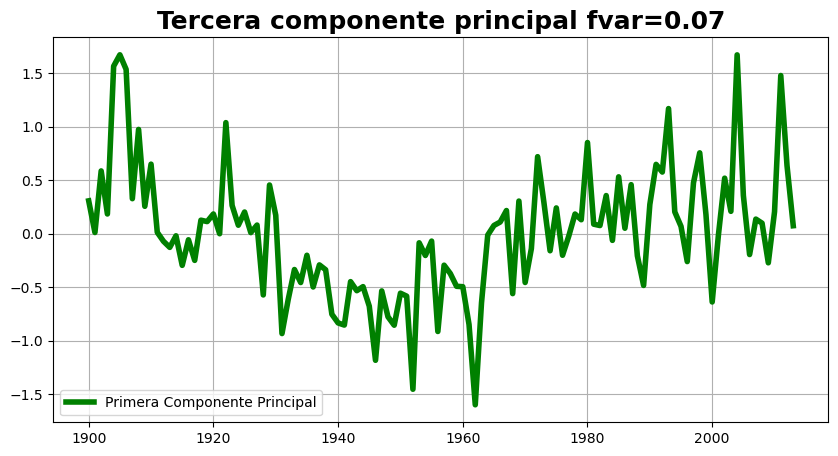

In [62]:
fig,ax=plt.subplots(figsize = (10,5))
ax.plot(range(1900,2014),PC1s[:,2],linewidth= 4,color='green',label='Primera Componente Principal')
ax.grid()
ax.legend()
ax.set_title('Tercera componente principal fvar='+ str( round(fvar_tn10[2],2)),fontsize=18,weight='bold')
